In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus
from glob import glob

from astroquery.simbad import Simbad
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astroquery.gaia import Gaia
import pandas as pd

## First creating a primary bias image

In [24]:
# going to be using this fuction a lot, so good to define it early

def display(data):
    plt.imshow(data,cmap='gray',vmin=np.percentile(data,5),vmax=np.percentile(data,97),origin='lower')
    plt.colorbar()
    plt.show()

In [ ]:
filenames = glob('bias/bias/bias*.fits')
print(len(filenames)) # Print the number of files
print(filenames[:3]) # See what the first three filenames look like

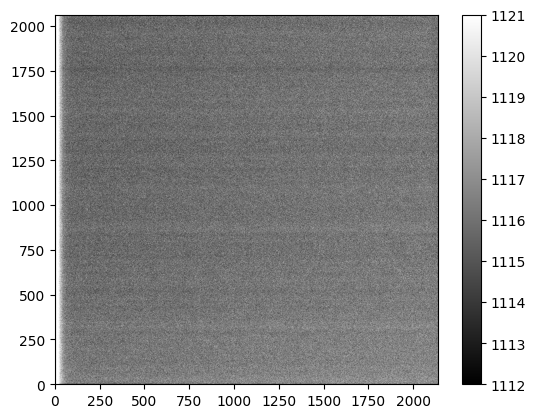

In [26]:
# Let's inspect the data for one of the bias images from PRISM
data0 = fits.getdata(filenames[0])
display(data0)

In [27]:
datastack = np.zeros((len(filenames),data0.shape[0]-9,data0.shape[1]-148))
#print(type(datastack),datastack.shape)

In [28]:
for i,filename in enumerate(filenames):
    preclip = fits.getdata(filename)
    datastack[i] = preclip[5:2060,55:2045]

In [29]:
primarybias = np.median(datastack,axis=0)
#print('Mean:',np.mean(primarybias))

In [ ]:
header = fits.getheader(filenames[0])
newheader = header.copy()
newheader['COMMENT'] = "primary bias"
newheader['COMMENT'] = str(len(filenames))+" frames median combined"
newheader['COMMENT'] = "processed by Raul Lama"
newheader

fits.writeto("PrimaryBias.fits",primarybias,newheader,overwrite=True)

## No darks for PTO because operating temp is very low, so now to do this process for the flats in each band

## V Band Flats

In [ ]:
flatVfiles = glob('flat_v/flat_v/flat_v*.fits')
sampleVflat = fits.getdata(flatVfiles[0])

flatV_stack = np.zeros((len(flatVfiles),sampleVflat.shape[0]-9,sampleVflat.shape[1]-148))

for i,filename in enumerate(flatVfiles):
    preclipflatV = fits.getdata(filename)
    flatV_ds = preclipflatV[5:2060,55:2045] - primarybias
    flatV_stack[i] = flatV_ds / np.median(flatV_ds)

med_flatV = np.median(flatV_stack,axis=0)
debiasedprimaryflatV = med_flatV / np.median(med_flatV)

flatV_header = fits.getheader(flatVfiles[0])
newheader_flatV = flatV_header.copy()
newheader_flatV['COMMENT'] = "primary V-band flat"
newheader_flatV['COMMENT'] = str(len(filenames))+" frames median combined"
newheader_flatV['COMMENT'] = "processed by Raul Lama"

fits.writeto("PrimaryFlatV.fits",debiasedprimaryflatV,newheader_flatV,overwrite=True)
#newheader_flatV

## B Band Flats

In [ ]:
flatBfiles = glob('flat_b/flat_b/flat_b*.fits')
sampleBflat = fits.getdata(flatBfiles[0])

flatB_stack = np.zeros((len(flatBfiles),sampleBflat.shape[0]-9,sampleBflat.shape[1]-148))

for i,filename in enumerate(flatBfiles):
    preclipflatB = fits.getdata(filename)
    flatB_ds = preclipflatB[5:2060,55:2045] - primarybias
    flatB_stack[i] = flatB_ds / np.median(flatB_ds)

med_flatB = np.median(flatB_stack,axis=0)
debiasedprimaryflatB = med_flatB / np.median(med_flatB)

flatB_header = fits.getheader(flatBfiles[0])
newheader_flatB = flatB_header.copy()
newheader_flatB['COMMENT'] = "primary B-band flat"
newheader_flatB['COMMENT'] = str(len(filenames))+" frames median combined"
newheader_flatB['COMMENT'] = "processed by Raul Lama"

fits.writeto("PrimaryFlatB.fits",debiasedprimaryflatB,newheader_flatB,overwrite=True)
#newheader_flatB

## R Band Flats

In [ ]:
flatRfiles = glob('flat_r/flat_r/flat_r*.fits')
sampleRflat = fits.getdata(flatRfiles[0])

flatR_stack = np.zeros((len(flatRfiles),sampleRflat.shape[0]-9,sampleRflat.shape[1]-148))

for i,filename in enumerate(flatRfiles):
    preclipflatR = fits.getdata(filename)
    flatR_ds = preclipflatR[5:2060,55:2045] - primarybias
    flatR_stack[i] = flatR_ds / np.median(flatR_ds)

med_flatR = np.median(flatR_stack,axis=0)
debiasedprimaryflatR = med_flatR / np.median(med_flatR)

flatR_header = fits.getheader(flatRfiles[0])
newheader_flatR = flatR_header.copy()
newheader_flatR['COMMENT'] = "primary R-band flat"
newheader_flatR['COMMENT'] = str(len(filenames))+" frames median combined"
newheader_flatR['COMMENT'] = "processed by Raul Lama"

fits.writeto("PrimaryFlatR.fits",debiasedprimaryflatR,newheader_flatR,overwrite=True)
#newheader_flatR

## Now to do reductions in each band

## V Band Reduction

In [ ]:
rawimagesV = sorted(glob('science_v/science*.fits'))
hdr0V = fits.getheader(rawimagesV[0])


for im in rawimagesV:
    with fits.open(im) as hdul:
        data = hdul[0].data
        clippeddata = data[5:2060,55:2045]
        reduced = (clippeddata - primarybias) / debiasedprimaryflatV
        hdr = hdul[0].header
        hdr['COMMENT'] = "Image bias-subtracted and flat-fielded"
        hdr['COMMENT'] = "Calibrated by Raul Lama"
        fits.writeto('CScience_V/c'+im.split('/')[1],reduced,header=hdr,overwrite=True)

## B Band Reduction

In [ ]:
rawimagesB = sorted(glob('science_b/science*.fits'))
hdr0B = fits.getheader(rawimagesB[0])
#rawimagesB

for im in rawimagesB:
    with fits.open(im) as hdul:
        data = hdul[0].data
        clippeddata = data[5:2060,55:2045]
        reduced = (clippeddata - primarybias) / debiasedprimaryflatB
        hdr = hdul[0].header
        hdr['COMMENT'] = "Image bias-subtracted and flat-fielded"
        hdr['COMMENT'] = "Calibrated by Raul Lama"
        fits.writeto('CScience_B/c'+im.split('/')[1],reduced,header=hdr,overwrite=True)

## R Band Reduction

In [ ]:
rawimagesR = sorted(glob('science_r/science*.fits'))
hdr0R = fits.getheader(rawimagesR[0])
#rawimagesR

for im in rawimagesR:
    with fits.open(im) as hdul:
        data = hdul[0].data
        clippeddata = data[5:2060,55:2045]
        reduced = (clippeddata - primarybias) / debiasedprimaryflatR
        hdr = hdul[0].header
        hdr['COMMENT'] = "Image bias-subtracted and flat-fielded"
        hdr['COMMENT'] = "Calibrated by Raul Lama"
        fits.writeto('CScience_R/c'+im.split('/')[1],reduced,header=hdr,overwrite=True)

## Let's do some science

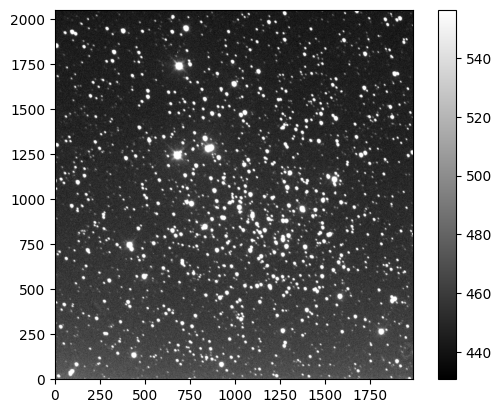

In [ ]:
frame_V = fits.getdata('CScience_V/cscience030.fits')
display(frame_V)

(<matplotlib.patches.Circle at 0x7feaa95c3010>,)

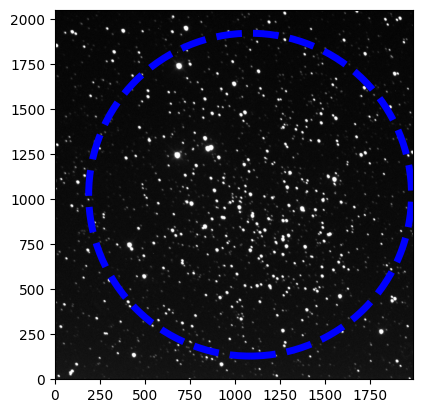

In [60]:
plt.figure()
plt.imshow(frame_V,cmap='gray',vmin=np.percentile(frame_V,5),vmax=np.percentile(frame_V,99),origin='lower')
ap = CircularAperture((1085,1026), r = 350/0.39)
ap.plot(color = 'blue', linestyle = '--', lw = 5.)


In [79]:
pos = coords.SkyCoord('07h37m30.05s -12d04m23.53s') # location of Mel71 in RA and DEC

table = Simbad.list_tables()

#Simbad.get_field_description("mespm")
Simbad.reset_votable_fields()
Simbad.add_votable_fields("mespm")
info_simbad = Simbad.query_region('07h37m30.05s -12d04m23.53s', radius = 350*u.arcsec) # query a region around to get cluster candidates
info_simbad


main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,mespm.bibcode,mespm.coosystem,mespm.mespos,mespm.pmde,mespm.pmde_err,mespm.pmde_err_prec,mespm.pmde_prec,mespm.pmra,mespm.pmra_err,mespm.pmra_err_prec,mespm.pmra_prec
,deg,deg,mas,mas,deg,,,,,,mas / yr,mas / yr,,,mas / yr,mas / yr,,
object,float64,float64,float32,float32,int16,str1,object,object,object,int16,float32,float32,int16,int16,float32,float32,int16,int16
Gaia DR3 3033959335920232960,114.43049426008128,-12.042360132808055,0.0316,0.0276,90,O,2020yCat.1350....0G,2020yCat.1350....0G,ICRS,1,4.391,0.033,3,3,-2.477,0.04,3,3
Gaia DR3 3033959335920232960,114.43049426008128,-12.042360132808055,0.0316,0.0276,90,O,2020yCat.1350....0G,2018yCat.1345....0G,ICRS,2,4.386,0.069,3,3,-2.708,0.087,3,3
Gaia DR3 3033962492716975360,114.36458187767711,-12.02307501714639,0.0713,0.0637,90,O,2020yCat.1350....0G,2020yCat.1350....0G,ICRS,1,4.09,0.077,3,3,-2.266,0.093,3,3
Gaia DR3 3033962492716975360,114.36458187767711,-12.02307501714639,0.0713,0.0637,90,O,2020yCat.1350....0G,2018yCat.1345....0G,ICRS,2,4.039,0.155,3,3,-2.227,0.197,3,3
Gaia DR3 3033962806253911424,114.30581695046291,-12.03604139805139,0.0603,0.0537,90,O,2020yCat.1350....0G,2020yCat.1350....0G,ICRS,1,4.176,0.063,3,3,-2.525,0.077,3,3
Gaia DR3 3033962806253911424,114.30581695046291,-12.03604139805139,0.0603,0.0537,90,O,2020yCat.1350....0G,2018yCat.1345....0G,ICRS,2,4.209,0.166,3,3,-2.515,0.171,3,3
Gaia DR3 3033962565735646336,114.39049678789667,-12.020366338263058,0.0495,0.0446,90,O,2020yCat.1350....0G,2020yCat.1350....0G,ICRS,1,4.487,0.053,3,3,-2.306,0.064,3,3
Gaia DR3 3033962565735646336,114.39049678789667,-12.020366338263058,0.0495,0.0446,90,O,2020yCat.1350....0G,2018yCat.1345....0G,ICRS,2,4.58,0.108,3,3,-2.226,0.139,3,3


In [80]:
column_name = info_simbad['mespm.pmra']
average_value = info_simbad['mespm.pmra'].mean()
filtered_values = info_simbad[(info_simbad['mespm.pmra'] >= average_value - 0.5) & (info_simbad['mespm.pmra'] <= average_value + 0.5)]['mespm.pmra']
#print(filtered_values)


In [81]:
average_value

np.float64(-2.3774113604061387)

In [85]:
table = info_simbad[(info_simbad['mespm.pmra'] >= average_value - 0.5) & (info_simbad['mespm.pmra'] <= average_value + 0.5)]['main_id','ra','dec','mespm.pmra']
table

main_id,ra,dec,mespm.pmra
,deg,deg,mas / yr
object,float64,float64,float32
Gaia DR3 3033959335920232960,114.43049426008128,-12.042360132808055,-2.477
Gaia DR3 3033959335920232960,114.43049426008128,-12.042360132808055,-2.708
Gaia DR3 3033962492716975360,114.36458187767711,-12.02307501714639,-2.266
Gaia DR3 3033962492716975360,114.36458187767711,-12.02307501714639,-2.227
Gaia DR3 3033962806253911424,114.30581695046291,-12.03604139805139,-2.525
Gaia DR3 3033962806253911424,114.30581695046291,-12.03604139805139,-2.515
Gaia DR3 3033962565735646336,114.39049678789667,-12.020366338263058,-2.306
Gaia DR3 3033962565735646336,114.39049678789667,-12.020366338263058,-2.226


In [ ]:
wcs = fits.open('wcs.fits')
h_wcs = fits.getheader('wcs.fits')
h_wcs['NAXIS1'] = h_wcs['IMAGEW']
h_wcs['NAXIS2'] = h_wcs['IMAGEH']
#h_wcs

CRVAL1 = h_wcs['CRVAL1']
CRVAL2 = h_wcs['CRVAL2']
CRPIX1 = h_wcs['CRPIX1']
CRPIX2 = h_wcs['CRPIX2']

CD1_1 = h_wcs['CD1_1']
CD1_2 = h_wcs['CD1_2']
CD2_1 = h_wcs['CD2_1']
CD2_2 = h_wcs['CD2_2']

RA = []
DEC = []

for i in table:
    c = coords.SkyCoord(i['ra'], i['dec'], frame='icrs', unit=(u.deg, u.deg))
    RA.append(c.ra.degree)
    DEC.append(c.dec.degree)

from astropy.wcs import WCS

w = WCS(h_wcs)
#px, py = w.wcs_world2pix(CRVAL1, CRVAL2, 0)
#print((px, py))

x_c, y_c = w.wcs_world2pix(RA, DEC, 0)

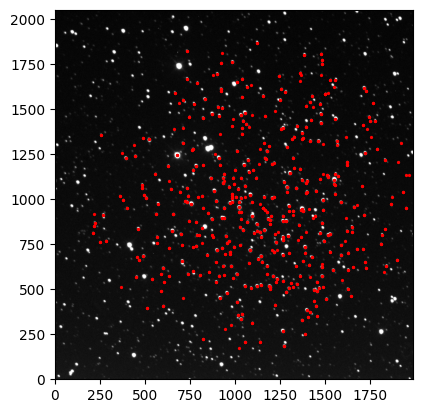

In [143]:
plt.figure(2)
plt.imshow(frame_V,cmap='gray',vmin=np.percentile(frame_V,5),vmax=np.percentile(frame_V,99),origin='lower')
plt.scatter(x_c, y_c, marker='.',s=7, c='r')

In [144]:
Object = []
PM_pmra = []

for i in table:
    Object.append(i['main_id'])
    PM_pmra.append(i['mespm.pmra'])

new_tab = pd.DataFrame({"Object":Object})
new_tab.insert(1,"RA",RA)
new_tab.insert(2,'DEC',DEC)
new_tab.insert(3,'PM_pmra',PM_pmra)
new_tab.insert(4,'X Centroid',x_c)
new_tab.insert(5,'Y Centroid',y_c)
new_tab

,Object,RA,DEC,PM_pmra,X Centroid,Y Centroid
0,Gaia DR3 3033959335920232960,114.430494,-12.042360,-2.477,1588.698351,744.816019
1,Gaia DR3 3033959335920232960,114.430494,-12.042360,-2.708,1588.698351,744.816019
2,Gaia DR3 3033962492716975360,114.364582,-12.023075,-2.266,992.570498,561.469348
3,Gaia DR3 3033962492716975360,114.364582,-12.023075,-2.227,992.570498,561.469348
4,Gaia DR3 3033962806253911424,114.305817,-12.036041,-2.525,458.872520,677.572367
...,...,...,...,...,...,...
805,Gaia DR3 3033952670131198848,114.341004,-12.128083,-2.507,771.224385,1532.780249
806,Gaia DR3 3033958854883960832,114.434622,-12.090527,-2.347,1622.485886,1191.396685
807,Gaia DR3 3033958854883960832,114.434622,-12.090527,-2.509,1622.485886,1191.396685
808,UCAC4 390-032741,114.347779,-12.130442,-2.415,832.455183,1555.099391


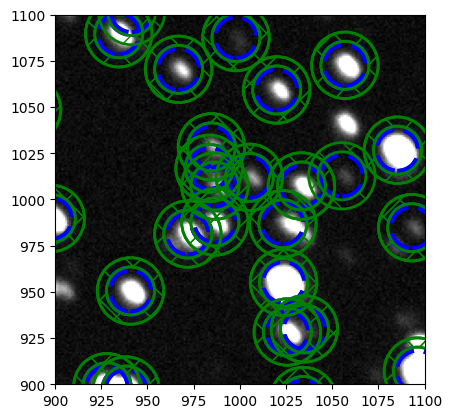

In [145]:
coordinates_list = list(zip(x_c, y_c))

plt.figure()
plt.imshow(frame_V, cmap = 'gray', vmin = np.percentile(frame_V, 5), vmax = np.percentile(frame_V, 99), origin = 'lower')
centroids = [(x,y) for x,y in coordinates_list]

ap = CircularAperture(centroids, r = 12)
ap.plot(color = 'blue', linestyle = '--', lw = 5.)

skyan = CircularAnnulus(centroids, r_in = 13, r_out = 18)
skyan.plot(color = 'green', hatch = 'x', lw = 2)

plt.xlim(900,1100)
plt.ylim(900,1100)
plt.show()

### There is a lot of overlap with the apertures which can be remedied by Point Spred Function (PSF) photometry.

In [146]:
starapsum = ap.do_photometry(frame_V)[0]

skysum = skyan.do_photometry(frame_V)[0]

averagesky = skysum/skyan.area

starsum = starapsum - ap.area*averagesky

vmag_comp = 12.687 #target, from Simbad

fluxratio = starsum / starsum[0]

m_V = -2.5 * np.log10(fluxratio) + vmag_comp

for i in range(len(m_V)):
    if(np.isnan(m_V[i])):
        m_V[i] = 0
#m_V = -2.5*np.log10(fluxratio) + vmag_comp #mag

<ipython-input-146-f114de8ba222>:13: RuntimeWarning: invalid value encountered in log10
  m_V = -2.5 * np.log10(fluxratio) + vmag_comp


### Now for B filter

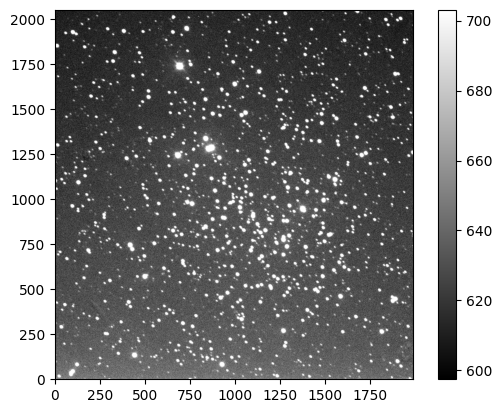

In [ ]:
frame_B = fits.getdata('CScience_B/cscience034.fits')
display(frame_B)

In [ ]:
wcs_B = fits.open('wcs_B.fits')
h_wcs_B = fits.getheader('wcs_B.fits')
h_wcs_B['NAXIS1'] = h_wcs_B['IMAGEW']
h_wcs_B['NAXIS2'] = h_wcs_B['IMAGEH']

CRVAL1 = h_wcs_B['CRVAL1']
CRVAL2 = h_wcs_B['CRVAL2']
CRPIX1 = h_wcs_B['CRPIX1']
CRPIX2 = h_wcs_B['CRPIX2']

CD1_1 = h_wcs_B['CD1_1']
CD1_2 = h_wcs_B['CD1_2']
CD2_1 = h_wcs_B['CD2_1']
CD2_2 = h_wcs_B['CD2_2']

RA_B = []
DEC_B = []

for i in table:
    c = coords.SkyCoord(i['ra'], i['dec'], frame='icrs', unit=(u.deg, u.deg))
    RA_B.append(c.ra.degree)
    DEC_B.append(c.dec.degree)

from astropy.wcs import WCS

w_B = WCS(h_wcs_B)
px_B, py_B = w_B.wcs_world2pix(CRVAL1, CRVAL2, 0)
#print((px, py))

x_c_B, y_c_B = w_B.wcs_world2pix(RA_B, DEC_B, 0)

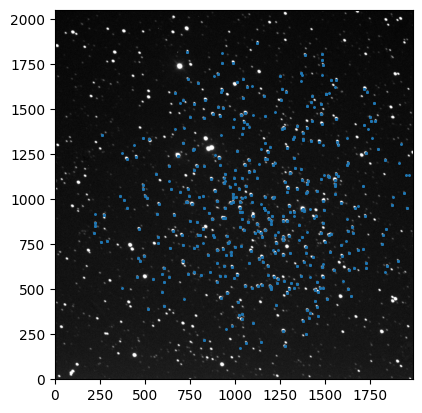

In [149]:
plt.figure(3)
plt.imshow(frame_B,cmap='gray',vmin=np.percentile(frame_B,5),vmax=np.percentile(frame_B,99),origin='lower')
plt.scatter(x_c_B, y_c_B, marker='.',s=5)

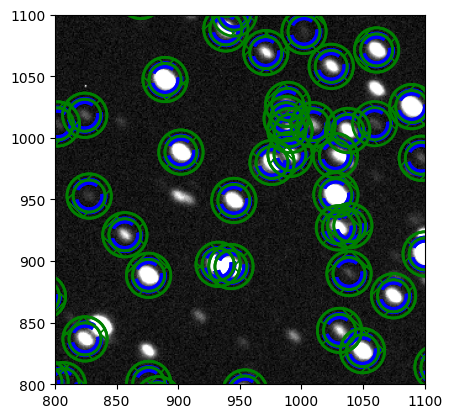

In [150]:
coordinates_list = list(zip(x_c_B, y_c_B))

plt.figure()
plt.imshow(frame_B, cmap = 'gray', vmin = np.percentile(frame_B, 5), vmax = np.percentile(frame_B, 99), origin = 'lower')
centroids = [(x,y) for x,y in coordinates_list]

ap = CircularAperture(centroids, r = 12)
ap.plot(color = 'blue', linestyle = '--', lw = 5.)

skyan = CircularAnnulus(centroids, r_in = 13, r_out = 18)
skyan.plot(color = 'green', hatch = 'x', lw = 2)

plt.xlim(800,1100)
plt.ylim(800,1100)
plt.show()

In [151]:
starapsum = ap.do_photometry(frame_B)[0]

skysum = skyan.do_photometry(frame_B)[0]

averagesky = skysum/skyan.area

starsum = starapsum - ap.area*averagesky

bmag_comp = 13.786 #target, from Simbad

fluxratio = starsum / starsum[0]

m_B = -2.5*np.log10(fluxratio) + bmag_comp #mag

for i in range(len(m_B)):
    if(np.isnan(m_B[i])):
        m_B[i] = 0

<ipython-input-151-bcfea6a10771>:13: RuntimeWarning: invalid value encountered in log10
  m_B = -2.5*np.log10(fluxratio) + bmag_comp #mag


### Now we want B-V which can tell us the color of our stars (the lower the number the hotter a star is)

In [153]:
B_V = m_B-m_V

for i in range(len(B_V)):
    if(np.isnan(B_V[i])):
        B_V[i] = 0

#B_V

new_tab.insert(6,'B Magnitude',m_B)
new_tab.insert(7,'V Magntiude',m_V)
new_tab.insert(8,'B-V',B_V)
new_tab

,Object,RA,DEC,PM_pmra,X Centroid,Y Centroid,B Magnitude,V Magntiude,B-V
0,Gaia DR3 3033959335920232960,114.430494,-12.042360,-2.477,1588.698351,744.816019,13.786000,12.687000,1.099000
1,Gaia DR3 3033959335920232960,114.430494,-12.042360,-2.708,1588.698351,744.816019,13.786000,12.687000,1.099000
2,Gaia DR3 3033962492716975360,114.364582,-12.023075,-2.266,992.570498,561.469348,16.658663,15.057582,1.601081
3,Gaia DR3 3033962492716975360,114.364582,-12.023075,-2.227,992.570498,561.469348,16.658663,15.057582,1.601081
4,Gaia DR3 3033962806253911424,114.305817,-12.036041,-2.525,458.872520,677.572367,0.000000,14.829572,-14.829572
...,...,...,...,...,...,...,...,...,...
805,Gaia DR3 3033952670131198848,114.341004,-12.128083,-2.507,771.224385,1532.780249,12.940564,11.880413,1.060152
806,Gaia DR3 3033958854883960832,114.434622,-12.090527,-2.347,1622.485886,1191.396685,13.999750,12.742873,1.256877
807,Gaia DR3 3033958854883960832,114.434622,-12.090527,-2.509,1622.485886,1191.396685,13.999750,12.742873,1.256877
808,UCAC4 390-032741,114.347779,-12.130442,-2.415,832.455183,1555.099391,10.981592,10.070254,0.911338


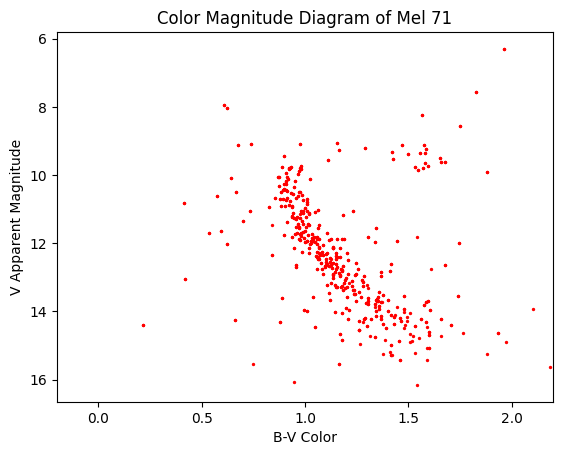

In [154]:
count = 0
for i in range(len(m_V)):
    plt.figure(5)
    if(m_V[i] != 0 and B_V[i] != 0 and B_V[i] > -10):
        count += 1
        plt.scatter(B_V[i],m_V[i], c='red', s = 2)
        plt.gca().invert_yaxis()
        plt.xlim(-0.2,2.2)
        #plt.axvline(x=0.35)
        #plt.axhline(y=13)
        plt.ylabel("V Apparent Magnitude")
        plt.xlabel("B-V Color")
        plt.title("Color Magnitude Diagram of Mel 71")

In [155]:
count

737